In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/traffic-jam/

/content/drive/MyDrive/traffic-jam


In [10]:
import numpy as np
import pandas as pd
import os
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
%matplotlib inline

# I. Load dataset

In [ ]:
# !pip install patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.4 MB/s eta 0:00:00


In [ ]:
# import patoolib
# rar_file = './data/data.rar'
# patoolib.extract_archive(rar_file)
# df = pd.read_csv("./data.csv")
# max = df['Timestamp'].max()
# get_timestamp = np.arange(0.0, max, 1.0)
# df_filtered = df[df['Timestamp'].isin(get_timestamp)]
# df_filtered.to_csv('dataset.csv',index=False)


In [ ]:
os.listdir()

['data', 'report', 'trained', 'traffic-jam-prediction.ipynb', 'best_model']

In [4]:
df = pd.read_csv("./data/data_fixed.csv")

print(df.head())
print(df.shape)

   Node  Timestamp          X           Y  Velocity  Duration  \
0     0        0.0  21.001976  105.850775      0.00       0.0   
1     0        1.0  21.001987  105.850776      2.24       0.0   
2     0        2.0  21.002017  105.850780      4.18       0.0   
3     0        3.0  21.002064  105.850786      6.14       0.0   
4     0        4.0  21.002128  105.850795      8.17       0.0   

         Road Type Road Condition Road Event  Congestion  
0     38136736#5_0         Smooth     Others           0  
1     38136736#5_0         Smooth     Others           0  
2     38136736#5_0         Smooth     Others           0  
3  :6658619199_1_0         Smooth     Others           0  
4     38136736#6_0         Smooth     Others           0  
(2103952, 10)


In [22]:
road_type = pd.DataFrame(list(df['Road Type'].value_counts().index), columns=['Road Type'])
road_type.to_csv('road_type.csv', index=False)

In [ ]:
df[df['Congestion'] == 1.0]

,Node,Timestamp,X,Y,Velocity,Duration,Road Type,Road Condition,Road Event,Congestion
835,10,97.0,21.007767,105.841631,0.0,5.6,813363002#1_2,Smooth,Accident,1
836,10,98.0,21.007767,105.841631,0.0,6.6,813363002#1_2,Smooth,Accident,1
837,10,99.0,21.007767,105.841631,0.0,7.6,813363002#1_2,Smooth,Accident,1
838,10,100.0,21.007767,105.841631,0.0,8.6,813363002#1_2,Smooth,Accident,1
839,10,101.0,21.007767,105.841631,0.0,9.6,813363002#1_2,Smooth,Accident,1
...,...,...,...,...,...,...,...,...,...,...
2103947,78,175199.0,21.007968,105.845990,0.0,82.3,704626468#1_3,Smooth,Accident,1
2103948,83,175199.0,21.003175,105.847953,0.0,90.7,953227387#5_1,Smooth,Accident,1
2103949,88,175199.0,21.008088,105.846117,0.0,95.2,838419179#4_2,Smooth,Accident,1
2103950,92,175199.0,21.003559,105.847658,0.0,63.8,472431976#11_0,Smooth,Accident,1


In [ ]:
df['Timestamp'].value_counts().sort_index()

In [ ]:
# # Xác định khoảng timestamp cách nhau 20.0
# bin_edges = range(0, int(df['Timestamp'].max()) + 21, 20)
# # print(bin_edges)

# # Nhóm các hàng theo khoảng timestamp
# df['TimestampGroup'] = pd.cut(df['Timestamp'], bins=bin_edges, include_lowest=True)
# # print(df)

# # Hàm xử lý để xóa các hàng có Congestion = 0 trong mỗi nhóm
# def remove_zero_congestion(group):
#     if (group['Congestion'] == 1).any():
#         return group[group['Congestion'] != 0]
#     return group

# # Áp dụng hàm xử lý cho mỗi nhóm
# df_filtered = df.groupby('TimestampGroup').apply(remove_zero_congestion)

# # Xóa cột TimestampGroup không cần thiết
# df_filtered.drop(columns='TimestampGroup', inplace=True)
# df_filtered.reset_index(drop=True, inplace=True)
# df_filtered.to_csv('./data/data_fixed.csv', index=False)

### Convert time
| Thực tể      | Mô phỏng |
| ----------- | ----------- |
| 1 ngày      | 480s       |
| 1 h   | 480/24 = 20s        |
| 1 min      | 20/60 = 1/3s       |
| 1 s   | 1/3 * 1/60 = 1/180 s        |

In [ ]:
from datetime import datetime

# date in string format
start_time_simulate = "01.01.2022 00:00:00"

# convert to datetime instance
date_time = datetime.strptime(start_time_simulate, '%d.%m.%Y %H:%M:%S')
print(date_time)

# timestamp in seconds
start_timestamp = date_time.timestamp()
print(start_timestamp)

2022-01-01 00:00:00
1640995200.0


In [ ]:
import datetime
def convert_to_timeslot(timestamp):
  # Định nghĩa khoảng thời gian và định dạng ngày-giờ
  time_interval = datetime.timedelta(minutes=30)
  date_format = '%Y-%m-%d %H:%M:%S'

  # Tạo một timestamp ví dụ (dạng giây)
  timestamp = 1626010200

  # Chuyển đổi timestamp sang kiểu datetime
  dt = datetime.datetime.fromtimestamp(timestamp)

  # Trích xuất ngày từ datetime
  date = dt.date()

  # Tạo datetime bắt đầu của ngày đó
  start_time = datetime.datetime.combine(date, datetime.time(0, 0, 0))

  # Tính thời gian đã trôi qua kể từ thời điểm bắt đầu ngày
  time_passed = dt - start_time

  # Chia thời gian đã trôi qua thành khoảng thời gian
  interval_index = int(time_passed.total_seconds() / time_interval.total_seconds())

  return interval_index

convert_to_timeslot(1640995200.0)

27

In [ ]:
def convert(simulate_second):
  base_convert = 86400 / 480
  real_second = simulate_second * base_convert
  return real_second

In [ ]:
df.Timestamp = df.Timestamp.apply(lambda x: start_timestamp + convert(x))

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

In [ ]:
df['MonthOfYear'] = pd.DatetimeIndex(df['Timestamp']).month
df['DayOfMonth'] = pd.DatetimeIndex(df['Timestamp']).day
df['DayOfWeek'] = pd.DatetimeIndex(df['Timestamp']).dayofweek
df['Timeslot'] = df['Timestamp'].apply(lambda x: convert_to_timeslot(x))

In [ ]:
df.head()

,Node,Timestamp,X,Y,Velocity,Duration,Road Type,Road Condition,Road Event,Congestion,MonthOfYear,DayOfMonth,DayOfWeek,Timeslot
0,0,2022-01-01 00:00:00,21.001976,105.850775,0.00,0.0,38136736#5_0,Smooth,Others,0,1,1,5,27
1,0,2022-01-01 00:03:00,21.001987,105.850776,2.24,0.0,38136736#5_0,Smooth,Others,0,1,1,5,27
2,0,2022-01-01 00:06:00,21.002017,105.850780,4.18,0.0,38136736#5_0,Smooth,Others,0,1,1,5,27
3,0,2022-01-01 00:09:00,21.002064,105.850786,6.14,0.0,:6658619199_1_0,Smooth,Others,0,1,1,5,27
4,0,2022-01-01 00:12:00,21.002128,105.850795,8.17,0.0,38136736#6_0,Smooth,Others,0,1,1,5,27


## Explore data

<Axes: >

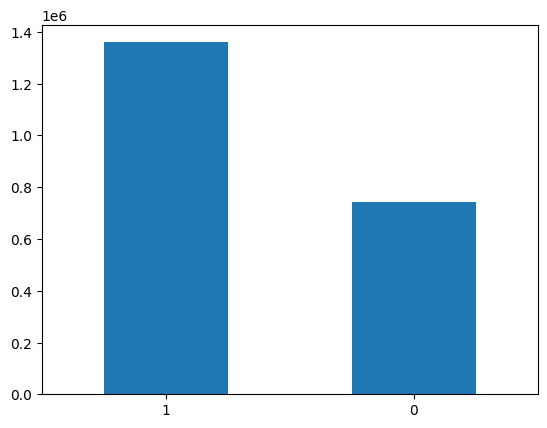

In [ ]:
df['Congestion'].value_counts().plot.bar(rot=0)

In [ ]:
# def plot_cat_cols_with_target(data, cols, target):
#     for col in cols:
#         pd.crosstab(data[col], data[target]).plot.bar(figsize=(20, 10), fontsize=18)
#     plt.show()

# cat_cols = ["Node", "Timestamp", "Road Type"]
# plot_cat_cols_with_target(df, cat_cols, "Road Event")

## Preprocess data

### LDBPE Input

In [5]:
from sklearn import preprocessing
lb_encoder = preprocessing.LabelEncoder()

In [6]:
ldbpe_features = ['Timestamp', 'Velocity', 'Duration', 'Road Type', 'Congestion']
ldbpe_data = df[ldbpe_features]

In [7]:
ldbpe_data['Road Type'] = lb_encoder.fit_transform(ldbpe_data['Road Type'])

<ipython-input-7-b81010522b03>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldbpe_data['Road Type'] = lb_encoder.fit_transform(ldbpe_data['Road Type'])


In [ ]:
ldbpe_scaler = MinMaxScaler()
ldbpe_data[['Timestamp', 'Velocity', 'Duration', 'Road Type']] = ldbpe_scaler.fit_transform(ldbpe_data[['Timestamp', 'Velocity', 'Duration', 'Road Type']])

<ipython-input-77-9f7cf742f027>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldbpe_data[['Timestamp', 'Velocity', 'Duration', 'Road Type']] = ldbpe_scaler.fit_transform(ldbpe_data[['Timestamp', 'Velocity', 'Duration', 'Road Type']])


In [9]:
joblib.dump(ldbpe_scaler, 'ldbpe_minmax_model.pkl')

NameError: ignored

In [11]:
joblib.dump(lb_encoder, 'ldbpe_encoder_model.pkl')

['ldbpe_encoder_model.pkl']

In [ ]:
ldbpe_data

,Timestamp,Velocity,Duration,Road Type,Congestion
0,0.0,0.00,0.0,184,0
1,1.0,2.24,0.0,184,0
2,2.0,4.18,0.0,184,0
3,3.0,6.14,0.0,757,0
4,4.0,8.17,0.0,185,0
...,...,...,...,...,...
2103947,175199.0,0.00,82.3,263,1
2103948,175199.0,0.00,90.7,410,1
2103949,175199.0,0.00,95.2,335,1
2103950,175199.0,0.00,63.8,201,1


In [ ]:
def generator(df, look_back = 48, timesteps=20, num_features=4):
  bin_edges = range(0, int(df['Timestamp'].max()) + timesteps + 1, timesteps)
  # Nhóm các hàng theo khoảng timestamp
  df['TimestampGroup20'] = pd.cut(df['Timestamp'], bins=bin_edges, include_lowest=True)
  ldbpe_features = ['Timestamp', 'Velocity', 'Duration', 'Road Type']
  timeslot_range = list(df.groupby('TimestampGroup20').size().sort_index().index)
  max_rows = df.groupby('TimestampGroup20').size().max()

  samples = np.zeros((look_back, max_rows, num_features))
  labels = np.zeros((look_back,))

  j = 0
  while j+look_back-1 < len(timeslot_range):
    k = 0
    for i in range(j, j+look_back-1):
      data = df[df['TimestampGroup20'] == timeslot_range[i]]
      padding_zero = np.zeros((max_rows - len(data), data.shape[1]))
      data = pd.concat([data, pd.DataFrame(padding_zero, columns=data.columns)])
      samples[k] = data[ldbpe_features]
      labels[k] = 0 if len(data[data['Congestion'] == 1]) <= 0 else 1
      k+=1

    j+=look_back
    yield samples, labels

### HDBPE Input

In [ ]:
hdbpe_features = ['Timestamp', 'X', 'Y', 'Congestion']
hdbpe_data = df[hdbpe_features]

In [ ]:
hdbpe_data.Congestion.value_counts()

1    1360176
0     743776
Name: Congestion, dtype: int64

In [ ]:
# hdbpe_data.to_csv('./data/hdbpe_dataset.csv',index=False)

In [ ]:
hdbpe_data.shape

(2103952, 4)

<Axes: >

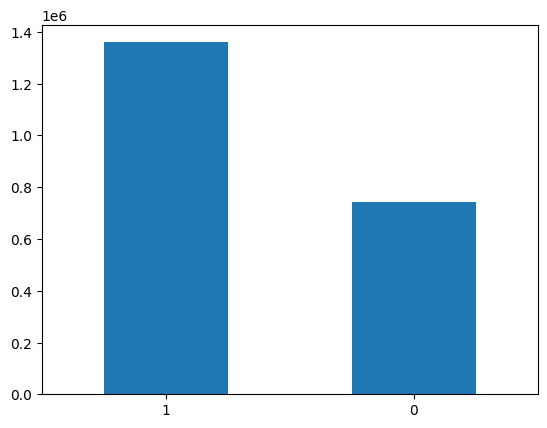

In [ ]:
hdbpe_data.Congestion.value_counts().plot.bar(rot=0)

In [ ]:
hbdpe_scaler = MinMaxScaler()
hdbpe_data[['Timestamp', 'X', 'Y']] = hbdpe_scaler.fit_transform(hdbpe_data[['Timestamp', 'X', 'Y']])

<ipython-input-23-dd09bde2593c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hdbpe_data[['Timestamp', 'X', 'Y']] = hbdpe_scaler.fit_transform(hdbpe_data[['Timestamp', 'X', 'Y']])


In [ ]:
import joblib

joblib.dump(hbdpe_scaler, 'hbdpe_minmax_model.pkl')

['hbdpe_minmax_model.pkl']

In [ ]:
X_hdbpe = hdbpe_data[['Timestamp', 'X', 'Y']]
y_hdbpe = hdbpe_data['Congestion']

### Project data with PCA

In [ ]:
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

def display(df):
  # PCA
  pca = PCA(n_components=3)
  principalComponents = pca.fit_transform(df[df.columns[:-1]])
  principalDf = pd.DataFrame(data = principalComponents,  columns = ['x', 'y', 'z'])
  finalDf = pd.concat([principalDf, df['Congestion']], axis = 1)

  # Visualize
  fig = plt.figure(figsize = (8,8))
  ax = plt.axes(projection='3d')
  # ax = fig.add_subplot(1,1,1)
  ax.set_xlabel('x', fontsize = 15)
  ax.set_ylabel('y', fontsize = 15)
  ax.set_zlabel('z', fontsize = 15)
  ax.set_title('Data visualization\n', fontsize = 20)

  label_dict = {
      0: 'No Traffic Jam',
      1: 'Traffic Jam',
  }

  keys = [*label_dict.keys()]
  targets = [*label_dict.values()]
  colors = ['#FF0000', '#00FF00']
  for key, color in zip(keys, colors):
    print(key)
    indicesToKeep = finalDf['Congestion'] == key
    print(indicesToKeep.shape)
    ax.scatter3D(finalDf.loc[indicesToKeep, 'x']
              , finalDf.loc[indicesToKeep, 'y']
              , finalDf.loc[indicesToKeep, 'z']
              , c = color
                , s = 30)
  ax.legend(targets)
  ax.grid()

  return ax

# II. Model

### Utils Function

#### Display result of training

In [ ]:
def displays(history):
  # summarize history for accuracy
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

#### Save report to csv file

In [ ]:
def save_classification(y_test, y_binary_pred, out_dir='./report/hdbpe.csv'):
  label_dict = {0: 'Congestion', 1: 'No Congestion'}
  out = classification_report(y_test,y_binary_pred, output_dict=True)
  out_df = pd.DataFrame(out).transpose()
  for i in label_dict:
    temp = label_dict[i]
    out_df.rename(index={str(i): temp}, inplace=True)
  out_df.to_csv(out_dir)

  return out_df

### Historical Data-Based Probability Estimation

In [ ]:
from keras import Input, Model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.regularizers import l1

class HDBPEModel(Model):
    def __init__(self, num_features, name='HDBPEModel'):
#         super.__init__(name=name)
        self.num_features = num_features
        self.model_name = name

    def __call__(self, *args, **kwargs):
        inputs = Input(shape=(self.num_features,))
        x = Dense(256, activation='relu')(inputs)
        x = Dropout(rate=0.1)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(rate=0.1)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(rate=0.1)(x)
        outputs = Dense(2, activation='relu')(x)

        _model = Model(inputs=inputs, outputs=outputs, name = self.model_name)
        _model.summary()

        adam = Adam()

        _model.compile(
            optimizer=adam, loss='binary_crossentropy', metrics=['accuracy']
        )

        return _model

In [ ]:
def train_evaluate_hdbpe(X_train, X_test, y_train, y_test, historical_checkpoint_path, class_weight=None, out_dir='./report/hdbpe.csv'):
  model = HDBPEModel(num_features=X_train.shape[1])
  bin_model = model()

  historical_callback = ModelCheckpoint(filepath=historical_checkpoint_path,
                                        monitor='val_accuracy',
                                        mode='max',
                                        save_best_only=True)

  history = bin_model.fit(X_train, y_train, epochs=20, batch_size=128, class_weight=class_weight,
                          validation_split=0.05, callbacks=[historical_callback])

  displays(history)
  best_model = load_model(historical_checkpoint_path)

  y_pred = best_model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  print(classification_report(y_true=y_test, y_pred=y_pred))
  save_classification(y_test, y_pred, out_dir)

### Live Data-Based Probability Estimation

In [ ]:
from keras import Input, Model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.regularizers import l1

class LDBPEModel(Model):
    def __init__(self, num_features, name='Live Data-Based Probability Estimation Model'):
        super(LDBPEModel).__init__()
        self.num_features = num_features

    def __call__(self, *args, **kwargs):
        inputs = Input(shape=(None, self.num_features))
        x = LSTM(units=64, kernel_regularizer=l1(0.000001), return_sequences=True, recurrent_dropout=0.1)(inputs)
        x = Dropout(rate=0.2)(x)
        x = LSTM(units=64, kernel_regularizer=l1(0.000001), return_sequences=True, recurrent_dropout=0.1)(x)
        x = Dropout(rate=0.2)(x)
        x = LSTM(units=64, kernel_regularizer=l1(0.000001), recurrent_dropout=0.1)(x)
        x = Dropout(rate=0.2)(x)
        outputs = Dense(2, activation='relu')(x)

        _model = Model(inputs=inputs, outputs=outputs)
        _model.summary()

        adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        _model.compile(
            optimizer=adam, loss='binary_crossentropy', metrics=['accuracy']
        )

        return _model

In [ ]:
def train_evaluate_ldbpe(df_generator_train, ldbpe_validation_generator, df_generator_test, historical_checkpoint_path, class_weight=None):
  model = LDBPEModel(num_features=4)
  ldbpe_model = model()

  historical_callback = ModelCheckpoint(filepath=historical_checkpoint_path,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

  history = ldbpe_model.fit(df_generator_train, epochs=2, validation_data=ldbpe_validation_generator,
                                      class_weight=class_weight, callbacks=[historical_callback], steps_per_epoch=100, validation_steps=100)

  displays(history)
  best_model = load_model(historical_checkpoint_path)

  y_pred = best_model.predict(df_generator_test)
  y_pred = np.argmax(y_pred, axis=1)
  # print(classification_report(y_true=y_test, y_pred=y_pred))
  # save_classification(y_test, y_pred)

# III. Imbalanced Class

## For HDBPE Fine tuning

In [ ]:
X_hdbpe_train, X_hdbpe_test, y_hdbpe_train, y_hdbpe_test = train_test_split(X_hdbpe, y_hdbpe, test_size=0.2, random_state=42)

In [ ]:
display(hdbpe_data)

,Timestamp,X,Y,Congestion
0,0.000000,0.274855,0.733353,0
1,0.000006,0.275370,0.733412,0
2,0.000011,0.276777,0.733649,0
3,0.000017,0.278981,0.734004,0
4,0.000023,0.281983,0.734537,0
...,...,...,...,...
2103947,1.000000,0.555853,0.450133,1
2103948,1.000000,0.331082,0.566321,1
2103949,1.000000,0.561480,0.457650,1
2103950,1.000000,0.349090,0.548861,1


### No sampling

Model: "HDBPEModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 128)               512       
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 130       
                                                                 
Total params: 8,898
Trainable params: 8,898
Non-trainabl

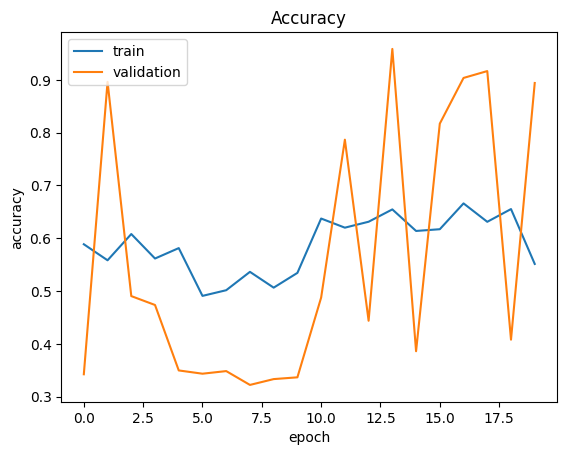

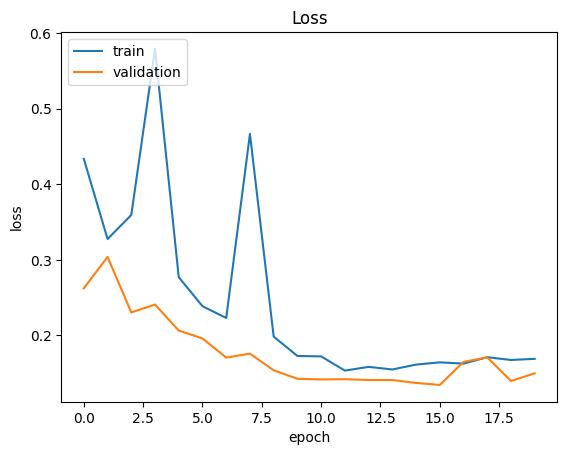

13150/13150 [==============================] - 19s 1ms/step
              precision    recall  f1-score   support

           0       0.68      0.92      0.78    148534
           1       0.94      0.76      0.84    272257

    accuracy                           0.82    420791
   macro avg       0.81      0.84      0.81    420791
weighted avg       0.85      0.82      0.82    420791



In [ ]:
historical_checkpoint_path = './trained/best_historical_model.model'
train_evaluate_hdbpe(X_hdbpe_train, X_hdbpe_test, y_hdbpe_train, y_hdbpe_test, historical_checkpoint_path)

### Undersampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)

X_under, y_under = rus.fit_resample(X_hdbpe, y_hdbpe)
# Plot class after undersampling
y_under.value_counts().plot.bar(rot=0)
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under, y_under, test_size=0.2, random_state=42)

In [ ]:
# Train
historical_checkpoint_path = './best_model/best_historical_under_model.model'
train_evaluate_hdbpe(X_under_train, X_under_test, y_under_train, y_under_test, historical_checkpoint_path)

### Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_over, y_over = smote.fit_resample(X, y)
y_over.value_counts().plot.bar(rot=0)
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(X_over, y_over, test_size=0.2, random_state=42)

In [ ]:
# Train
historical_checkpoint_path = './best_model/best_historical_over_model.model'
train_evaluate_hdbpe(X_over_train, X_over_test, y_over_train, y_over_test, historical_checkpoint_path)

### Hybridsampling

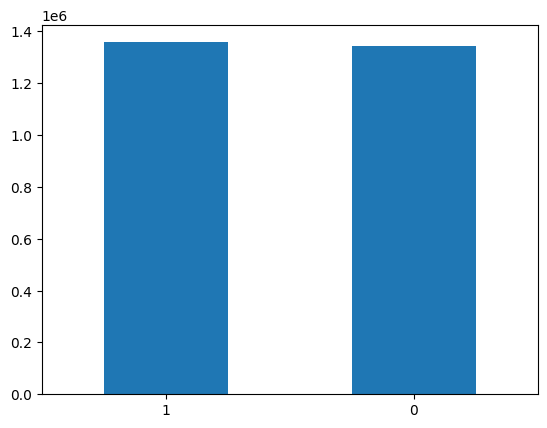

In [ ]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=2023)

X_hdbpe_hybrid, y_hdbpe_hybrid = smote_enn.fit_resample(X_hdbpe, y_hdbpe)
y_hdbpe_hybrid.value_counts().plot.bar(rot=0)
X_hdbpe_hybrid_train, X_hdbpe_hybrid_test, y_hdbpe_hybrid_train, y_hdbpe_hybrid_test = train_test_split(X_hdbpe_hybrid, y_hdbpe_hybrid, test_size=0.2, random_state=42)

In [ ]:
y_hdbpe.value_counts()

1    1360176
0     743776
Name: Congestion, dtype: int64

In [ ]:
y_hdbpe_hybrid.value_counts()

1    1357238
0    1341326
Name: Congestion, dtype: int64

Model: "HDBPEModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_12 (Dense)            (None, 256)               1024      
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dropout_11 (Dropout)        (None, 64)                0

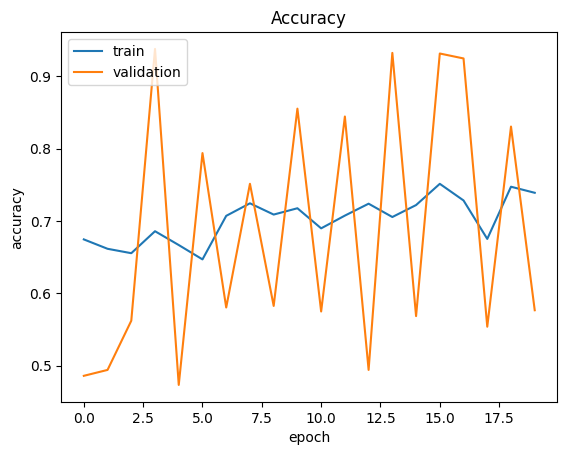

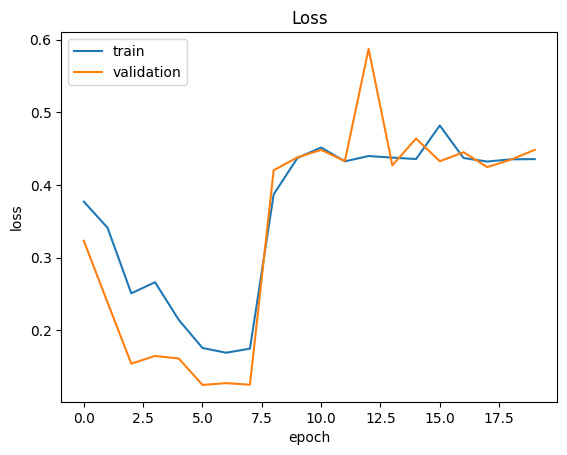

16867/16867 [==============================] - 28s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.88      0.93    268035
           1       0.90      0.99      0.94    271678

    accuracy                           0.94    539713
   macro avg       0.94      0.94      0.94    539713
weighted avg       0.94      0.94      0.94    539713



In [ ]:
historical_checkpoint_path = './best_model/best_historical_hybird_model.model'
train_evaluate_hdbpe(X_hdbpe_hybrid_train, X_hdbpe_hybrid_test, y_hdbpe_hybrid_train, y_hdbpe_hybrid_test, historical_checkpoint_path, out_dir = './report/hdbpe_hybrid.csv')

### Cost-sentitive

In [ ]:
import collections
import math

def create_class_weight(labels_dict, mu):
    """Create weight based on the number of domain name in the dataset"""
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = math.pow(total / float(labels_dict[key]), mu)
        class_weight[key] = score

    return class_weight

In [ ]:
labels_dict = collections.Counter(y_hdbpe_train)
# Create class weight
class_weight = create_class_weight(labels_dict=labels_dict, mu=0.8)

Model: "HDBPEModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_16 (Dense)            (None, 256)               1024      
                                                                 
 dropout_12 (Dropout)        (None, 256)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0

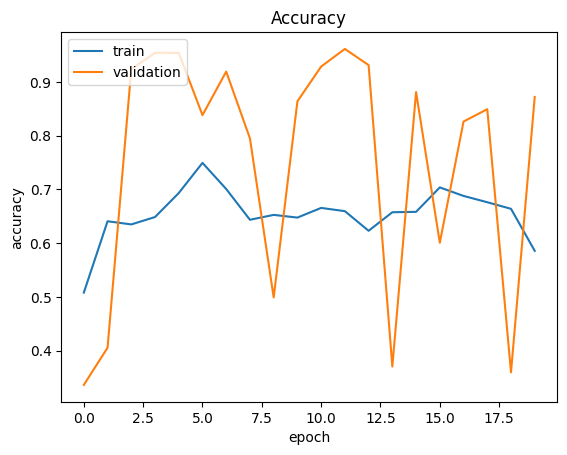

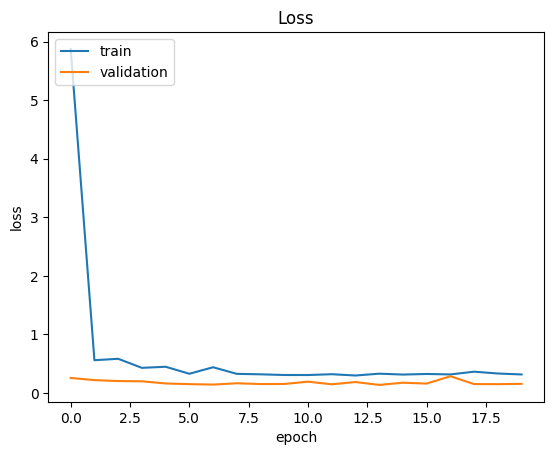

13150/13150 [==============================] - 21s 2ms/step
              precision    recall  f1-score   support

           0       0.96      0.93      0.94    148534
           1       0.96      0.98      0.97    272257

    accuracy                           0.96    420791
   macro avg       0.96      0.95      0.96    420791
weighted avg       0.96      0.96      0.96    420791



In [ ]:
historical_checkpoint_path = './best_model/best_historical_cost_model.model'
train_evaluate_hdbpe(X_hdbpe_train, X_hdbpe_test, y_hdbpe_train, y_hdbpe_test, historical_checkpoint_path, class_weight, './report/hdbpe_cost_sentitive.csv')

## For LDBPE Fine Tuning

In [ ]:
ldbpe_train, ldbpe_test = train_test_split(ldbpe_data, test_size=0.2, random_state=42)
ldbpe_train, ldbpe_validation = train_test_split(ldbpe_train, test_size=0.05, random_state=42)

In [ ]:
print(ldbpe_train.shape)
print(ldbpe_validation.shape)
print(ldbpe_test.shape)

(1599002, 5)
(84159, 5)
(420791, 5)


In [ ]:
ldbpe_train_generator = generator(ldbpe_train)
ldbpe_validation_generator = generator(ldbpe_validation)
ldbpe_test_generator = generator(ldbpe_test)

In [ ]:
len(list(ldbpe_train_generator))

182

In [ ]:
# next(ldbpe_train_generator)

#### No Sampling

In [ ]:
live_checkpoint_path = './best_model/best_live_model.model'
train_evaluate_ldbpe(ldbpe_train_generator, ldbpe_validation_generator, ldbpe_test_generator, live_checkpoint_path)

# Use model and predict

In [12]:
historical_checkpoint_path = './best_model/best_historical_hybird_model.model'
live_checkpoint_path = './best_model/best_live_model.model'

hdbpe_model = load_model(historical_checkpoint_path)
ldbpe_model = load_model(live_checkpoint_path)

In [14]:
import joblib

hbdpe_scaler = joblib.load('hbdpe_minmax_model.pkl')
lb_encoder = joblib.load('ldbpe_encoder_model.pkl')

In [15]:
hbdpe_input = np.array([97.0,	21.007767,	105.841631]).reshape(1, -1)
hbdpe_input = hbdpe_scaler.transform(hbdpe_input)
ldbpe_input = np.array([97.0, 0.0,	5.6,	lb_encoder.transform(['813363002#1_2'])[0]]).reshape(1, -1)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [16]:
hbdpe_pred = hdbpe_model.predict(hbdpe_input)
p1 = hbdpe_pred.max()
print(p1)

lbdpe_pred = ldbpe_model.predict(np.array([ldbpe_input]))
p2 = lbdpe_pred.max()
print(p2)

result = (p1 * p2) / ((p1 * p2) + (1 - p1) * (1 - p2))
result

1/1 [==============================] - 0s 298ms/step
0.66080713
1/1 [==============================] - 1s 747ms/step
0.0


0.0